## 1. Processing Logs

In [1]:
import re
import numpy as np
from matplotlib import pyplot as plt

In [2]:
PATTERN_TRAIN = r"\[.+\] \(.+\): INFO Train: \[[0-9\/]+\]\[[0-9\/]+\]\tETA: [0-9:]+\tlr [0-9\.]+\tBatch Time: [0-9\.]+ \([0-9\.]+\)\tLoss: [0-9\.]+ \(([0-9\.]+)\)\tGrad Norm: .+ \(.+\)\tMemory: [0-9]+MB\n\[.+\] \(.+\): INFO EPOCH ([0-9]+) training takes: [0-9:]+"
PATTERN_TEST = r"\[.+\] \(.+\): INFO Test: \[.+\]\tBatch Time: [0-9\.]+ \([0-9\.]+\)\tLoss: [0-9\.]+ \(([0-9\.]+)\)\tAcc@1: [0-9\.]+ \([0-9\.]+\)\tAcc@5: [0-9\.]+ \([0-9\.]+\)\tAccMany: [0-9\.]+ \([0-9\.]+\)\tAccMid: [0-9\.]+ \([0-9\.]+\)\tAccLow: [0-9\.]+ \([0-9\.]+\)\tMemory: [0-9]+MB\n\[.+\] \(.+\): INFO  -=-= Acc@1 ([0-9\.]+) Acc@5 ([0-9\.]+)[ ]+AccMany ([0-9\.]+) AccMid ([0-9\.]+) AccLow ([0-9\.]+)"

def get_model_training_results(log_path: str, pattern_train: str=PATTERN_TRAIN, pattern_test: str=PATTERN_TEST) -> tuple:
    with open(log_path, 'r') as f:
        txt = f.read()
        train_results = re.findall(pattern_train, txt)
        test_results = re.findall(pattern_test, txt)
    return train_results, test_results

LOG_PATHS = {
             "BSL": r"E:\Rivan\Tugas Akhir\MetaFormerBSL\output\MetaFG_meta_0\MetaFormer_0-iNat2018-Balanced_Softmax_Loss\log_rank_0.txt",
             "SL": r"E:\Rivan\Tugas Akhir\MetaFormerBSL\output\MetaFG_meta_0\MetaFormer_0-iNat2018-Softmax_Loss\log_rank_0.txt",
            }

results = {}
results["BSL_train"], results["BSL_test"] = get_model_training_results(log_path=LOG_PATHS["BSL"])
results["BSL_test"] = results["BSL_test"][3:] # throw away first 3 logs for BSL_test, cause of running errors
results["SL_train"], results["SL_test"] = get_model_training_results(log_path=LOG_PATHS["SL"])

# sanity check
for result in results.values():
    print("Array Sample:", result[-2:], "Length:", len(result))

Array Sample: [('3.1305', '149'), ('3.1337', '150')] Length: 150
Array Sample: [('0.9612', '88.074', '96.721', '84.075', '88.021', '89.178'), ('1.2432', '83.059', '94.874', '81.067', '83.383', '83.261')] Length: 300
Array Sample: [('3.1370', '149'), ('3.1284', '150')] Length: 150
Array Sample: [('1.1048', '83.759', '95.714', '87.915', '84.985', '81.141'), ('1.4861', '76.312', '92.942', '85.723', '78.400', '71.171')] Length: 300


In [3]:
hist_bsl = {}
hist_sl = {}

def split_training_history(train_data: list, test_data: list) -> dict:
    # check compatibility
    if len(train_data) != len(test_data)/2:
        raise ValueError("Incompatible train and test length.")

    epochs = len(train_data)
    hist = {}

    hist["epoch"] = list()
    hist["train_loss"] = list()

    hist["test_loss"] = list()
    hist["test_acc_1"] = list()
    hist["test_acc_5"] = list()
    hist["test_acc_many"] = list()
    hist["test_acc_mid"] = list()
    hist["test_acc_low"] = list()

    hist["test_loss_mask"] = list()
    hist["test_acc_1_mask"] = list()
    hist["test_acc_5_mask"] = list()
    hist["test_acc_many_mask"] = list()
    hist["test_acc_mid_mask"] = list()
    hist["test_acc_low_mask"] = list()

    for epoch in range(epochs):
        normal_test_index = 2 * epoch
        masked_test_index = 2 * epoch + 1
        
        hist["epoch"].append(train_data[epoch][1])
        hist["train_loss"].append(train_data[epoch][0])

        hist["test_loss"].append(test_data[normal_test_index][0])
        hist["test_acc_1"].append(test_data[normal_test_index][1])
        hist["test_acc_5"].append(test_data[normal_test_index][2])
        hist["test_acc_many"].append(test_data[normal_test_index][3])
        hist["test_acc_mid"].append(test_data[normal_test_index][4])
        hist["test_acc_low"].append(test_data[normal_test_index][5])

        hist["test_loss_mask"].append(test_data[masked_test_index][0])
        hist["test_acc_1_mask"].append(test_data[masked_test_index][1])
        hist["test_acc_5_mask"].append(test_data[masked_test_index][2])
        hist["test_acc_many_mask"].append(test_data[masked_test_index][3])
        hist["test_acc_mid_mask"].append(test_data[masked_test_index][4])
        hist["test_acc_low_mask"].append(test_data[masked_test_index][5])
    
    return hist

hist_bsl = split_training_history(train_data=results["BSL_train"], test_data=results["BSL_test"])
hist_sl = split_training_history(train_data=results["SL_train"], test_data=results["SL_test"])

In [4]:
# convert datas to float
for key in hist_bsl.keys():
    hist_bsl[key] = np.asarray(hist_bsl[key], dtype=float)
    hist_sl[key] = np.asarray(hist_sl[key], dtype=float)

In [5]:
def get_max_min(data: np.array, type: str) -> tuple:
    if type == "max":
        return (np.max(data), np.argmax(data))
    if type == "min":
        return (np.min(data), np.argmin(data))

def print_best_results(hist: dict):
    print("train_loss:", get_max_min(hist["train_loss"], "min"))

    print("test_loss:", get_max_min(hist["test_loss"], "min"))
    print("test_loss_mask:", get_max_min(hist["test_loss_mask"], "min"))
    
    print("test_acc_1:", get_max_min(hist["test_acc_1"], "max"))
    print("test_acc_1_mask:", get_max_min(hist["test_acc_1_mask"], "max"))

    print("test_acc_5:", get_max_min(hist["test_acc_5"], "max"))
    print("test_acc_5_mask:", get_max_min(hist["test_acc_5_mask"], "max"))
    
print("-= MetaFormerBSL Max/Min Stats (data, epoch-1) =-\n")
print_best_results(hist_bsl)
print("\n-= MetaFormer Max/Min Stats (data, epoch-1) =-\n")
print_best_results(hist_sl)

-= MetaFormerBSL Max/Min Stats (data, epoch-1) =-

train_loss: (3.1243, 145)
test_loss: (0.8813, 144)
test_loss_mask: (1.0886, 25)
test_acc_1: (88.103, 139)
test_acc_1_mask: (83.329, 139)
test_acc_5: (96.766, 145)
test_acc_5_mask: (94.874, 149)

-= MetaFormer Max/Min Stats (data, epoch-1) =-

train_loss: (3.1259, 144)
test_loss: (0.9063, 92)
test_loss_mask: (1.1488, 41)
test_acc_1: (84.5, 132)
test_acc_1_mask: (78.421, 143)
test_acc_5: (95.976, 146)
test_acc_5_mask: (93.622, 143)


## 2. Plots

In [6]:
TOTAL_EPOCHS = 150

### 2.1 MetaFormerBSL

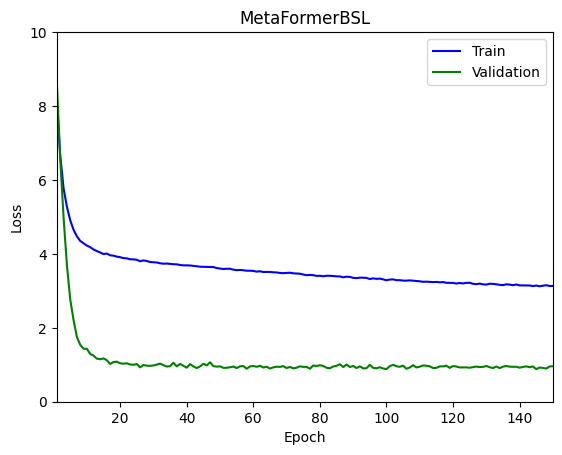

In [7]:
# Loss Plot

plt.plot(np.arange(1,hist_bsl["train_loss"].shape[0]+1), hist_bsl["train_loss"], label="Train", color='blue')
plt.plot(np.arange(1,hist_bsl["test_loss"].shape[0]+1), hist_bsl["test_loss"], label="Validation", color='green')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, TOTAL_EPOCHS)
plt.ylim(0, 10)
plt.title("MetaFormerBSL")
plt.legend()

Text(0.5, 1.0, 'MetaFormerBSL')

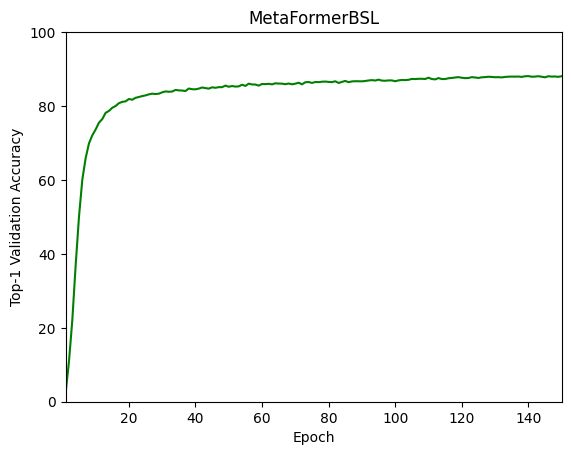

In [8]:
# Top-1 Accuracy Plot

plt.plot(np.arange(1,hist_bsl["test_acc_1"].shape[0]+1), hist_bsl["test_acc_1"], color='green')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Validation Accuracy")
plt.xlim(1, TOTAL_EPOCHS)
plt.ylim(0, 100)
plt.title("MetaFormerBSL")

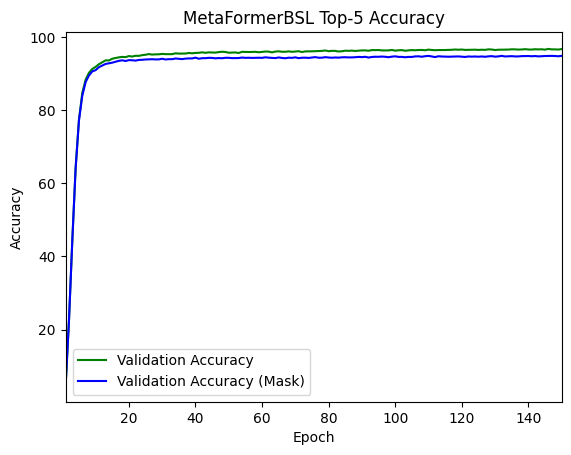

In [9]:
# Top-5 Accuracy Plot

plt.plot(np.arange(1,hist_bsl["test_acc_5"].shape[0]+1), hist_bsl["test_acc_5"], label="Validation Accuracy", color='green')
plt.plot(np.arange(1,hist_bsl["test_acc_5_mask"].shape[0]+1), hist_bsl["test_acc_5_mask"], label="Validation Accuracy (Mask)", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, TOTAL_EPOCHS)
plt.title("MetaFormerBSL Top-5 Accuracy")
plt.legend()

### 2.2 MetaFormer

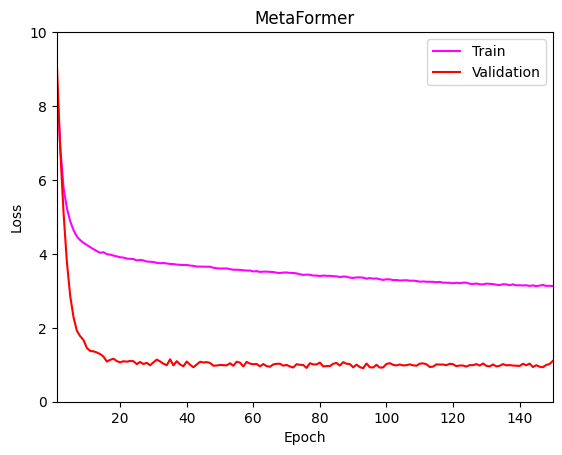

In [10]:
# Loss Plot

plt.plot(np.arange(1,hist_sl["train_loss"].shape[0]+1), hist_sl["train_loss"], label="Train", color='magenta')
plt.plot(np.arange(1,hist_sl["test_loss"].shape[0]+1), hist_sl["test_loss"], label="Validation", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, TOTAL_EPOCHS)
plt.ylim(0, 10)
plt.title("MetaFormer")
plt.legend()

Text(0.5, 1.0, 'MetaFormer')

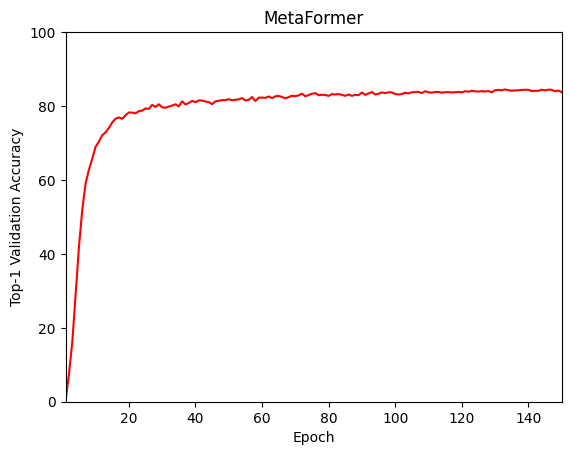

In [11]:
# Top-1 Accuracy Plot

plt.plot(np.arange(1,hist_sl["test_acc_1"].shape[0]+1), hist_sl["test_acc_1"], color='red')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Validation Accuracy")
plt.xlim(1, TOTAL_EPOCHS)
plt.ylim(0, 100)
plt.title("MetaFormer")

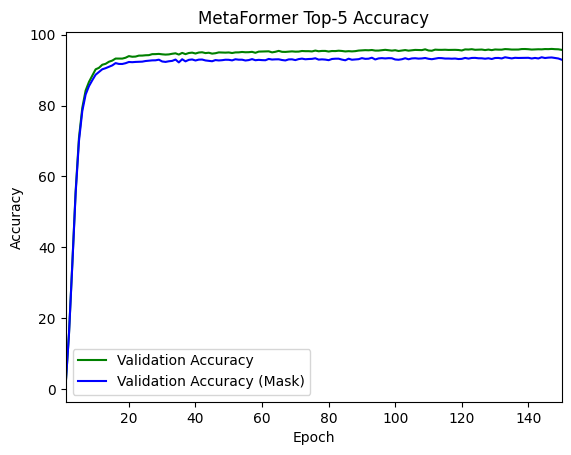

In [12]:
# Top-5 Accuracy Plot

plt.plot(np.arange(1,hist_sl["test_acc_5"].shape[0]+1), hist_sl["test_acc_5"], label="Validation Accuracy", color='green')
plt.plot(np.arange(1,hist_sl["test_acc_5_mask"].shape[0]+1), hist_sl["test_acc_5_mask"], label="Validation Accuracy (Mask)", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, TOTAL_EPOCHS)
plt.title("MetaFormer Top-5 Accuracy")
plt.legend()

### 2.3 MetaFormerBSL vs MetaFormer

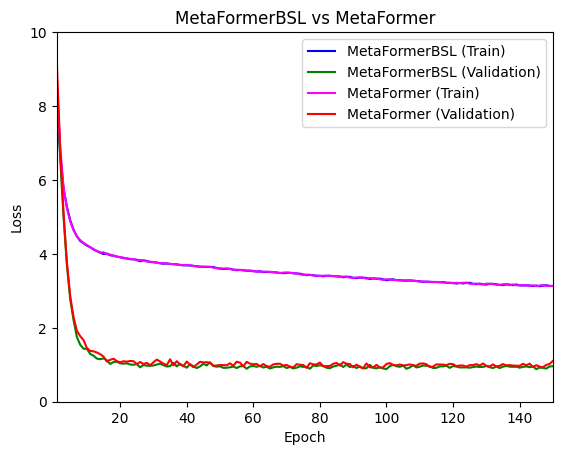

In [13]:
# Loss Plot

plt.plot(np.arange(1,hist_bsl["train_loss"].shape[0]+1), hist_bsl["train_loss"], label="MetaFormerBSL (Train)", color='blue')
plt.plot(np.arange(1,hist_bsl["test_loss"].shape[0]+1), hist_bsl["test_loss"], label="MetaFormerBSL (Validation)", color='green')
plt.plot(np.arange(1,hist_sl["train_loss"].shape[0]+1), hist_sl["train_loss"], label="MetaFormer (Train)", color='magenta')
plt.plot(np.arange(1,hist_sl["test_loss"].shape[0]+1), hist_sl["test_loss"], label="MetaFormer (Validation)", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, TOTAL_EPOCHS)
plt.ylim(0, 10)
plt.title("MetaFormerBSL vs MetaFormer")
plt.legend()

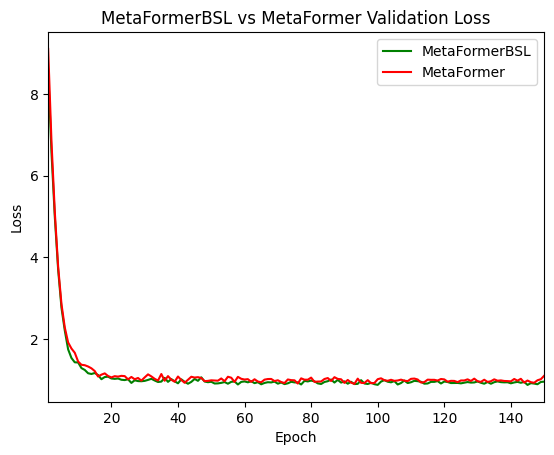

In [14]:
# Validation Loss Plot

plt.plot(np.arange(1,hist_bsl["test_loss"].shape[0]+1), hist_bsl["test_loss"], label="MetaFormerBSL", color='green')
plt.plot(np.arange(1,hist_sl["test_loss"].shape[0]+1), hist_sl["test_loss"], label="MetaFormer", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, TOTAL_EPOCHS)
plt.title("MetaFormerBSL vs MetaFormer Validation Loss")
plt.legend()

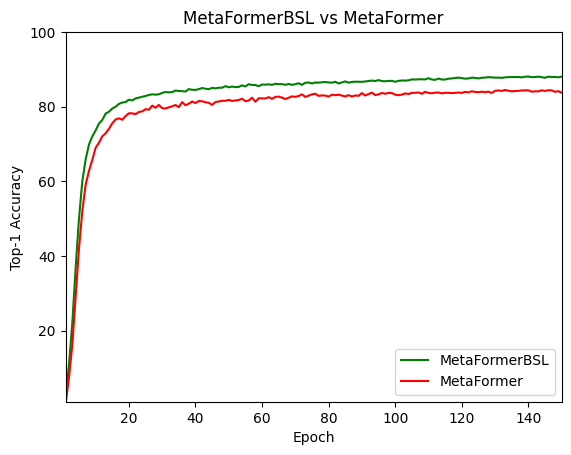

In [15]:
# Top-1 Accuracy Plot

plt.plot(np.arange(1,hist_bsl["test_acc_1"].shape[0]+1), hist_bsl["test_acc_1"], label="MetaFormerBSL", color='green')
plt.plot(np.arange(1,hist_sl["test_acc_1"].shape[0]+1), hist_sl["test_acc_1"], label="MetaFormer", color='red')
plt.xlabel("Epoch")
plt.ylabel("Top-1 Accuracy")
plt.xlim(1, TOTAL_EPOCHS)
plt.ylim(1, 100)
plt.title("MetaFormerBSL vs MetaFormer")
plt.legend(loc="lower right")

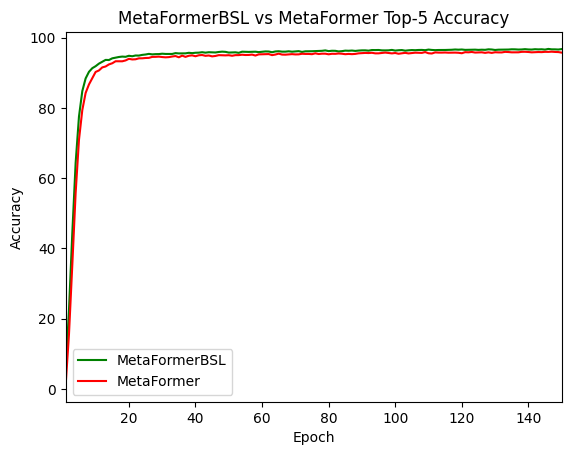

In [16]:
# Top-5 Accuracy Plot

plt.plot(np.arange(1,hist_bsl["test_acc_5"].shape[0]+1), hist_bsl["test_acc_5"], label="MetaFormerBSL", color='green')
plt.plot(np.arange(1,hist_sl["test_acc_5"].shape[0]+1), hist_sl["test_acc_5"], label="MetaFormer", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, TOTAL_EPOCHS)
plt.title("MetaFormerBSL vs MetaFormer Top-5 Accuracy")
plt.legend()

(0.0, 100.0)

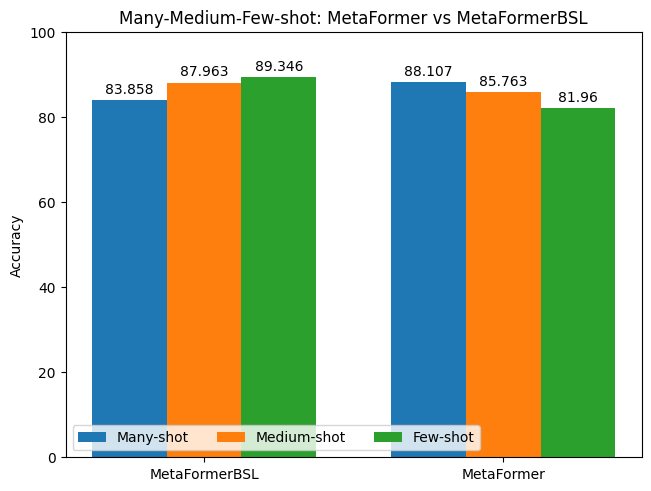

In [18]:
best_model_MetaFormerBSL = 139
best_model_MetaFormer = 132

models = ("MetaFormerBSL", "MetaFormer")
acc_data = {
    'Many-shot': (hist_bsl["test_acc_many"][best_model_MetaFormerBSL], hist_sl["test_acc_many"][best_model_MetaFormer]),
    'Medium-shot': (hist_bsl["test_acc_mid"][best_model_MetaFormerBSL], hist_sl["test_acc_mid"][best_model_MetaFormer]),
    'Few-shot': (hist_bsl["test_acc_low"][best_model_MetaFormerBSL], hist_sl["test_acc_low"][best_model_MetaFormer]),
}

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in acc_data.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Many-Medium-Few-shot: MetaFormer vs MetaFormerBSL')
ax.set_xticks(x + width, models)
ax.legend(loc='lower left', ncols=3)
ax.set_ylim(0, 100)